In [129]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [130]:
def create_motors(n_motors=10, d_lims=(0,10), th_lims=(-pi,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

# Planes

In [131]:
def rms_motor(results):
    rms_rot = []
    rms_mot = []
    rms_trs = []
    for result in results:
        (_, m, em, _) = result
#         print(m)
        
#         rot_error = np.min([np.linalg.norm(np.array(m.rot()) - np.array(em.rot())),
#                       np.linalg.norm(np.array(m.rot()) + np.array(em.rot()))])
#         rot = np.inner(rot_error, rot_error)
        
#         emm = em.rev() * m
#         angle_error = 2 * np.arccos(np.abs(emm[0]))
#         rot = angle_error**2
#         print('emm: ', rot)
        
        angle_error = 2 * np.arccos(np.abs(m[0])) - 2 * np.arccos(np.abs(em[0]))
        rot = angle_error**2
#         print(rot)
    
#         d = emm.trs()
#         print(m)
#         print(em)
#         print(m.trs())
#         print(em.trs())
#         print(m.trs() - em.trs())
#         print()
        d = np.array(m.trs() - em.trs())
        trs = np.inner(d,d)
        
        rl = m.rot()
        erl = em.rot()
        rerr = np.array((rl * erl.rev()).log())
        t = m.trs()
        et = em.trs()
        terr = np.array(t - et)
        
#         mot = np.linalg.norm(m * em.rev()) - 1.0
        
        rms_mot.append(np.inner(rerr,rerr) + np.inner(terr,terr))
        rms_rot.append(rot)
        rms_trs.append(trs)
        
#         print('m_during: ', m)
        
#     print()
        

    motmean = np.mean(rms_mot)
#     rotmean = np.mean(rms_rot)
    rotmean = np.sqrt(np.sum(rms_rot) / len(rms_rot))
    trsmean = np.sqrt(np.sum(rms_trs) / len(rms_trs)) 
    return (motmean, rotmean, trsmean)

In [132]:
def compare_rms_motor(results, results_vd, results_tin):
    RMS = {'Ti': {}, "VD": {}, 'Ti2': {}}
    our_mot, our_rot, our_trs = rms_motor(results)
    Ti = RMS['Ti']
    Ti['mot'] = our_mot
    Ti['rot'] = our_rot
    Ti['trs'] = our_trs
    _, vd_rot, _ = rms_motor(results_vd)
    VD = RMS['VD']
    VD['rot'] = vd_rot
    our_mot2, our_rot2, our_trs2 = rms_motor(results_tin)
    Ti2 = RMS['Ti2']
    Ti2['mot'] = our_mot2
    Ti2['rot'] = our_rot2
    Ti2['trs'] = our_trs2
    return pd.DataFrame(RMS)

In [145]:
def run_planes(n_planes=10, n_sets=10, n_motors=10, 
               trs_noise_std=0.0,
               rot_noise_std=0.0, 
               noisy=False):
    motors = create_motors(n_motors, d_lims=(0, 1), th_lims=(0,pi/2))
    results = []
    results_vd = []
    results_tin = []
    for n_set in range(n_sets):
        datasets = [create_random_planes(motor, n_planes, 
                                         rot_noise_std=rot_noise_std,
                                         trs_noise_std=trs_noise_std) 
                    for motor in motors]
        for dataset in datasets:
            results.append(estimate_motors_planes(dataset, noisy=noisy))
            results_vd.append(estimate_motors_planes_vd(dataset, noisy=noisy))
            results_tin.append(estimate_motors_planes(dataset, noisy=noisy, commutator=True))
    return (results, results_vd, results_tin)

In [146]:
def create_random_planes(motor, n_planes=10,
                        trs_noise_std=0.09, rot_noise_std=0.09):
    planes = []
    for i in range(n_planes):
        dir_vec = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        distance = np.random.uniform(0,1)
        a = vsr.Dlp(dir_vec,distance)
        b = a.spin(motor)
        if trs_noise_std > 0.0:
            t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,trs_noise_std,1)
        else:
            t = vsr.Vec(0,0,0)
            
        if rot_noise_std > 0.0:
            R = vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
                            np.random.normal(0, rot_noise_std) * -0.5)
        else:
            R = vsr.Rot(1,0,0,0)
        noise_motor = t.trs() * R
        
        bn = a.spin(noise_motor).spin(motor)
        planes.append((a,b,bn))
    return (planes, motor)

In [147]:
def estimate_motors_planes(dataset, 
                           initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                           noisy=False,
                          commutator=False):
    planes, motor = dataset
        
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in planes:
            if commutator:
                mes.add_dual_plane_commutator_residual_block(a,bn)
            else:
                mes.add_dual_plane_difference_residual_block(a,bn)
    else:
        for (a, b, _) in planes:
            if commutator:
                mes.add_dual_plane_commutator_residual_block(a,b)
            else:
                mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    return (planes, motor, estimated_motor, summary)

In [148]:
def estimate_motors_planes_lars(dataset, noisy=False):
    lines, motor = dataset
    
    def solve(L):
        Lrr = L[:4, :4]
        Lrq = L[:4, 4:]
        Lqr = L[4:, :4]
        Lqq = L[4:, 4:]
        Lp = Lrr - np.dot(Lrq, np.dot(np.linalg.pinv(Lqq), Lqr))
        w, v = np.linalg.eig(Lp)
        r = v[:, np.argmin(w)]
        q = np.dot(-np.dot(np.linalg.pinv(Lqq), Lqr), r)
        return vsr.Mot(*np.array([r, q]).ravel())

    Q = np.zeros((8,8))
        
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(vsr.CGA(a))
        lines_b.append(vsr.CGA(b))
        lines_bn.append(vsr.CGA(bn))
        
    if noisy:
        for b,a in zip(lines_a, lines_bn):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)
    else:
        for b,a in zip(lines_a, lines_b):
            D = np.zeros((32,8))
            for i in range(8):
                ei = vsr.Mot(0,0,0,0,0,0,0,0)
                ei[i] = 1.0
                ei = vsr.CGA(ei)
                D[:,i] = np.array(a * ei - ei * b)
            Q += np.dot(D.T,D)

    estimated_motor = solve(Q)
    if np.abs((estimated_motor * estimated_motor.rev())[7])  > 0.0000000001:
        print(wrong)
              
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
        
    return (lines, motor, estimated_motor, _)

In [149]:
def estimate_motors_planes_vd(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    vd = VDMotorEstimationSolver()
    planes, motor = dataset
    planes_a = []
    planes_b = []
    planes_bn = []
    for (a,b,bn) in planes:
        planes_a.append(a)
        planes_b.append(b)
        planes_bn.append(bn)
    if noisy:
        vd.add_dual_plane_observations(planes_a, planes_bn)
    else:
        vd.add_dual_plane_observations(planes_a, planes_b)

    estimated_motor = vd.solve()
        
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
    
    return (planes, motor, estimated_motor, [])

In [159]:
n_noise_levels = 10
noise_levels_rot = np.linspace(0.0, 0.1, n_noise_levels)
noise_levels_trs = np.linspace(0.0, 0.01, n_noise_levels)

rmss = [compare_rms_motor(*run_planes(32,32,32,
                                      trs_noise_std=noise_level_trs,
                                      rot_noise_std=noise_level_rot,
                                      noisy=True)) 
        for noise_level_rot, noise_level_trs in zip(noise_levels_rot, noise_levels_trs) ]

In [160]:
d = pd.concat(rmss)
d.T

,mot,rot,trs,mot,rot,trs,mot,rot,trs,mot,...,trs,mot,rot,trs,mot,rot,trs,mot,rot,trs
Ti,1.521064e-17,6.541406e-11,3.899194e-09,0.000003,0.001360,0.001335,0.000011,0.002848,0.002336,0.000028,...,0.007509,0.000158,0.009890,0.009160,0.000199,0.011206,0.010254,0.000321,0.012967,0.014049
Ti2,1.101645e-17,8.950844e-11,3.318250e-09,0.000004,0.001451,0.001496,0.000013,0.002968,0.002584,0.000033,...,0.008515,0.000192,0.010363,0.010518,0.000244,0.011722,0.011881,0.000416,0.014002,0.016578
VD,NaN,4.299193e-15,NaN,NaN,0.001359,NaN,NaN,0.002848,NaN,NaN,...,NaN,NaN,0.009891,NaN,NaN,0.011207,NaN,NaN,0.012967,NaN


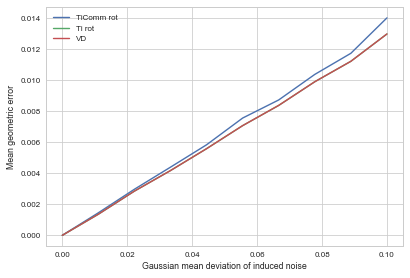

In [161]:
fig, ax = plt.subplots(1)

ax.plot(noise_levels_rot, d['Ti2']['rot'], label='TiComm rot')
ax.plot(noise_levels_rot, d['Ti']['rot'], label='Ti rot')
ax.plot(noise_levels_rot, d['VD']['rot'], label='VD')
ax.legend(frameon=False, loc=2)
ax.set_ylabel('Mean geometric error')
ax.set_xlabel('Gaussian mean deviation of induced noise')
# fig.savefig('/Users/lars/latex/latex-phd-thesis/Figures/planes-est-deviation.pdf')

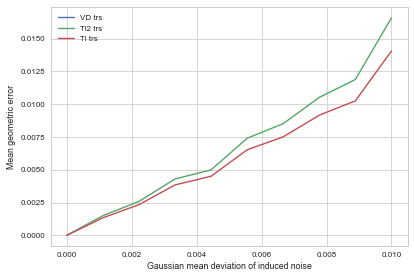

In [163]:
fig, ax = plt.subplots(1)

ax.plot(noise_levels, d['VD']['trs'], label='VD trs')
ax.plot(noise_levels_trs, d['Ti2']['trs'], label='Ti2 trs')
ax.plot(noise_levels_trs, d['Ti']['trs'], label='Ti trs')

ax.legend(frameon=False, loc=2)
ax.set_ylabel('Mean geometric error')
ax.set_xlabel('Gaussian mean deviation of induced noise')